In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import itertools
from os import path
import matplotlib.ticker as ticker
from scipy import stats
from sklearn.linear_model import LinearRegression

labels = ["paiceHusk", "krovetz", "sStripping", "porter2", "lovins", "wikt", "none"]
collection_n_values = [1,2,4,8,16,32,64,128,256]
collection_sizes = [52342886, 26171443, 13085721, 6542860, 3271430, 1635715, 817857, 408928, 204464]
data_dir_2013 = path.join("Data", "clueweb-2013")
data_dir_wikt = path.join("Data", "wikt")

### Preparing data

In [24]:
#Initialise data dictionary with column names and empty lists
data = {"n" : [], "size" : [], "stemmer" : [], "QID" : [], "nERR" : []}
data_avg = {"n" : [], "size" : [], "stemmer" : [], "nERR" : []}
QID = np.arange(201,251)
for n, size in zip(collection_n_values, collection_sizes):
    #Gather the data from each length file
    values = list()
    values_avg = list()
    queryTotal = 0
    with open(path.join(data_dir_2013,f"collectionSize/nERR-{n}"), "r") as f:
        for line in f:
            if line[0].isalpha(): 
                queryTotal = 0
                continue
            queryTotal+=1
            if queryTotal > 50:
                values_avg.append(float(line.strip()))
                continue
            values.append(float(line.strip()))
    i = 0
    for stemmer in labels:
        data["nERR"].extend(values[50*i:50*(i+1)])
        data["size"].extend([size for _ in QID])
        data["n"].extend([n for _ in QID])
        data["stemmer"].extend([stemmer for _ in QID])
        data["QID"].extend(QID)
        i+=1
    data_avg["nERR"].extend(values_avg)
    data_avg["size"].extend([size for _ in labels])
    data_avg["n"].extend([n for _ in labels])
    data_avg["stemmer"].extend(labels)
nERR_size = pd.DataFrame(data)
nERR_size_avg = pd.DataFrame(data_avg)
display(nERR_size)
display(nERR_size_avg)

,n,size,stemmer,QID,nERR
0,1,52342886,paiceHusk,201,0.342824
1,1,52342886,paiceHusk,202,0.063332
2,1,52342886,paiceHusk,203,0.547516
3,1,52342886,paiceHusk,204,0.367731
4,1,52342886,paiceHusk,205,0.000000
...,...,...,...,...,...
3145,256,204464,none,246,0.000000
3146,256,204464,none,247,0.000000
3147,256,204464,none,248,0.000000
3148,256,204464,none,249,0.000000


,n,size,stemmer,nERR
0,1,52342886,paiceHusk,0.373226
1,1,52342886,krovetz,0.381737
2,1,52342886,sStripping,0.397822
3,1,52342886,porter2,0.402487
4,1,52342886,lovins,0.369489
...,...,...,...,...
58,256,204464,sStripping,0.030661
59,256,204464,porter2,0.043286
60,256,204464,lovins,0.028857
61,256,204464,wikt,0.033667


### Average nERR-IA

In [18]:
best_nERR = list()
for size in collection_sizes:
    selected_data = nERR_size_avg[nERR_size_avg["size"] == size]
    best_nERR.append(selected_data["nERR"].max())

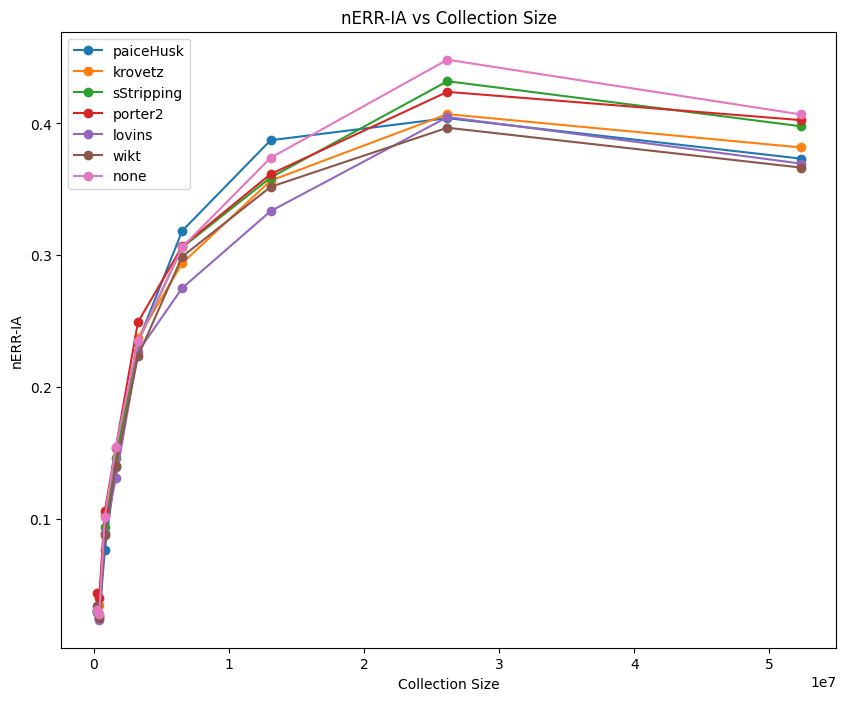

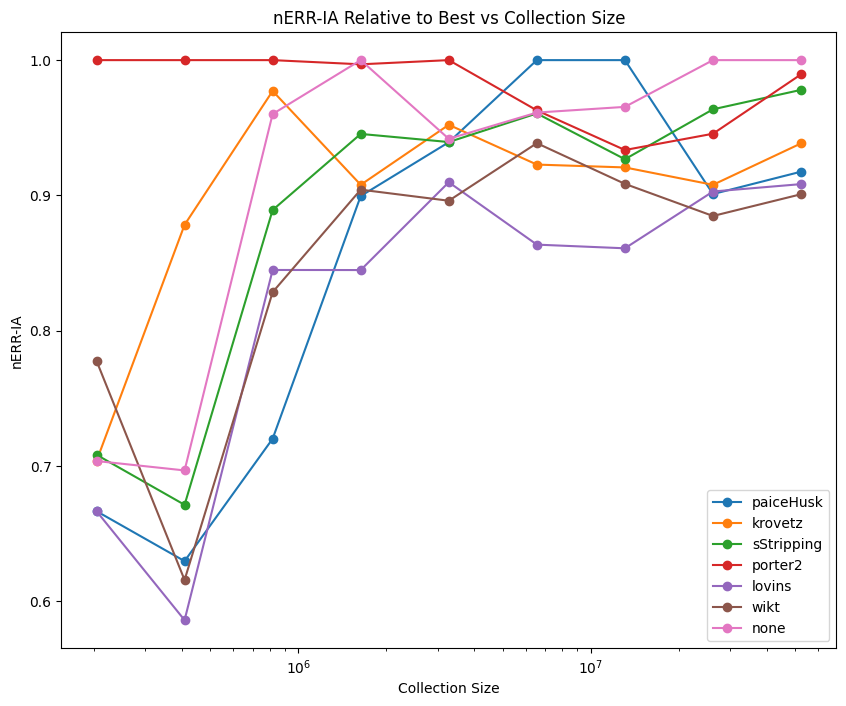

In [20]:
plt.figure(figsize=(10,8))
for stemmer in labels:
    stemmer_data = nERR_size_avg[nERR_size_avg["stemmer"] == stemmer]
    plt.plot(stemmer_data["size"], stemmer_data["nERR"], "o-", label=stemmer)

plt.title("nERR-IA vs Collection Size")
plt.xlabel("Collection Size")
plt.ylabel("nERR-IA")
plt.legend()

# ----------------------------------------------------------------------

plt.figure(figsize=(10,8))
for stemmer in labels:
    stemmer_data = nERR_size_avg[nERR_size_avg["stemmer"] == stemmer]
    stemmer_values = np.array(stemmer_data["nERR"])/best_nERR
    plt.plot(stemmer_data["size"], stemmer_values, "o-", label=stemmer)
    plt.xscale("log")

plt.title("nERR-IA Relative to Best vs Collection Size")
plt.xlabel("Collection Size")
plt.ylabel("nERR-IA")
plt.legend()

In [ ]:
sns.catplot(data=nERR_size_avg, kind="bar", x="stemmer", y="nERR", col="size", col_wrap=3)
plt.show()

### Results per query

In [ ]:
size = 52342886
nERR = nERR_size[nERR_size["size"] == size]
# for q in QID:
#     q_nERR = nERR[nERR["QID"] == q]
#     # print(f"Query ID: {q}")
#     # display(q_nERR[q_nERR["nERR"] == q_nERR["nERR"].max()])
#     # display(q_nERR[q_nERR["nERR"] == q_nERR["nERR"].min()])
#     display(q_nERR[q_nERR["stemmer"] == "none"])
#     display(q_nERR[q_nERR["stemmer"] == "wikt"])
#     print()

display(nERR[nERR["QID"] == 232])
    

### Statistical Significance

In [21]:
porter = list()
none = list()
for size in collection_sizes:
    p = list()
    n = list()
    target_data = nERR_size[nERR_size["size"] == size]
    p = target_data[target_data["stemmer"] == "porter2"].loc[:,"nERR"].tolist()
    n = target_data[target_data["stemmer"] == "none"].loc[:,"nERR"].tolist()
    print(f"Size: {size} {stats.ttest_rel(p,n)}")
    porter.extend(p)
    none.extend(n)
print()
print(f"Overall: {stats.ttest_rel(porter,none)}")

Size: 52342886 TtestResult(statistic=-0.1581571541596552, pvalue=0.8749829661699075, df=49)
Size: 26171443 TtestResult(statistic=-0.9087276528626319, pvalue=0.36794194921222156, df=49)
Size: 13085721 TtestResult(statistic=-0.7023624752404959, pvalue=0.48577644159445876, df=49)
Size: 6542860 TtestResult(statistic=0.04346373344528805, pvalue=0.9655085106833541, df=49)
Size: 3271430 TtestResult(statistic=1.0409229112446732, pvalue=0.30302028469811143, df=49)
Size: 1635715 TtestResult(statistic=-0.03257827982205025, pvalue=0.9741432347842839, df=49)
Size: 817857 TtestResult(statistic=0.3323565959407562, pvalue=0.7410376601476956, df=49)
Size: 408928 TtestResult(statistic=1.376573897005115, pvalue=0.17490191872180627, df=49)
Size: 204464 TtestResult(statistic=0.9999999999999999, pvalue=0.32222340595067556, df=49)

Overall: TtestResult(statistic=0.048715197589225774, pvalue=0.961167925946953, df=449)


### Linguistic Accuracy

In [26]:
nERR_fmeasure = nERR_size_avg[nERR_size_avg["stemmer"] != "none"]
averages = list()
for stemmer in labels[:-2]:
    fmeasures = np.loadtxt(path.join(data_dir_wikt,f"{stemmer}_cluster_fmeasures.csv"))
    averages.append(fmeasures.mean())
averages.append(1)
fmeasures = list()
for size in collection_sizes:
    fmeasures.extend(averages)
nERR_fmeasure["fmeasure"] = fmeasures

[0.8114746571901492, 0.7474362025911102, 0.6192389245427514, 0.7923311377151753, 0.7789375977759622, 1]


/tmp/ipykernel_25453/248806063.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nERR_fmeasure["fmeasure"] = fmeasures


In [ ]:
MARKERS = ["o","^","s","*","d","x"]
COLORS = ["tab:red","tab:orange","tab:green","tab:blue","tab:purple","tab:pink"]

graph = sns.lmplot(nERR_size_avg, x="nERR", y="fmeasure", hue="stemmer", markers=MARKERS, palette=COLORS, col="size", col_wrap=3, facet_kws={"sharex": False}, fit_reg=False)

for collection_size, ax in zip(np.unique(nERR_size_avg["size"]), graph.axes):
    target_data = nERR_fmeasure[nERR_fmeasure["size"] == collection_size]
    sns.regplot(target_data, x="nERR", y="fmeasure", scatter=False, ci=None, ax=ax)
plt.subplots_adjust(hspace=0.3)
plt.show()

In [ ]:
for size in collection_sizes:
    x = nERR_fmeasure[nERR_fmeasure["size"] == size]["nERR"].to_numpy()
    y = nERR_fmeasure[nERR_fmeasure["size"] == size]["fmeasure"].to_numpy()
    print(f"Size: {size} {stats.pearsonr(x,y)}")
x = nERR_fmeasure["nERR"].to_numpy()
y = nERR_fmeasure["fmeasure"].to_numpy()
print(f"Overall: {stats.pearsonr(x,y)}")